In [2]:
import tensorflow as tf


In [3]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLWAIXL/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLWAIXL/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLWAIXL/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []


for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [5]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [6]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of 

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [8]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 14s 18ms/step - loss: 0.5263 - accuracy: 0.7102 - val_loss: 0.3510 - val_accuracy: 0.8479
Epoch 2/50
782/782 [==============================] - 14s 17ms/step - loss: 0.2982 - accuracy: 0.8796 - val_loss: 0.3616 - val_accuracy: 0.8454
Epoch 3/50
782/782 [==============================] - 14s 17ms/step - loss: 0.2253 - accuracy: 0.9133 - val_loss: 0.3830 - val_accuracy: 0.8437
Epoch 4/50
782/782 [==============================] - 14s 17ms/step - loss: 0.1659 - accuracy: 0.9381 - val_loss: 0.4541 - val_accuracy: 0.8390
Epoch 5/50
782/782 [==============================] - 13s 17ms/step - loss: 0.1180 - accuracy: 0.9592 - val_loss: 0.5323 - val_accuracy: 0.8316
Epoch 6/50
782/782 [==============================] - 14s 17ms/step - loss: 0.0802 - accuracy: 0.9744 - val_loss: 0.6131 - val_accuracy: 0.8288
Epoch 7/50
782/782 [==============================] - 14s 18ms/step - loss: 0.0571 - accuracy: 0.9813 - val_loss: 0.7168 - val_accuracy:

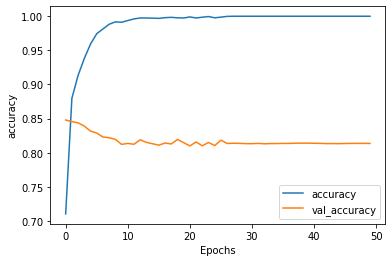

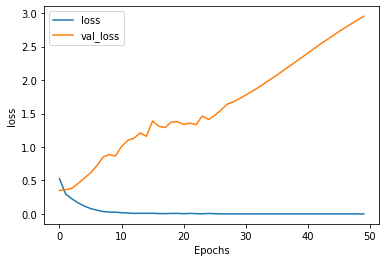

In [9]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')